In [ ]:
%pip install transformers torch datasets evaluate accelerate timm kagglehub pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
df = pd.read_csv("datasets/ColBERT_Humor_Detection.csv")
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


/home/maxime/miniconda3/envs/ia/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

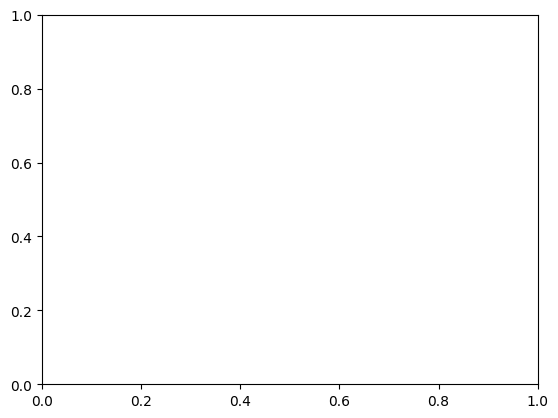

In [3]:
# repartition des classes
import matplotlib.pyplot as plt
plt.hist(df['humor'])
plt.show()

Utilisation de la colonne texte : 'text'



/tmp/ipykernel_91424/4137132412.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')


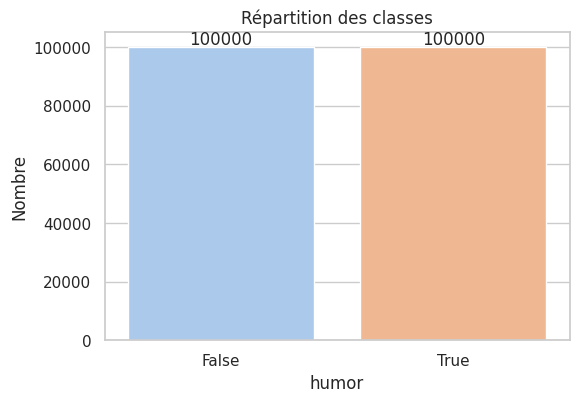

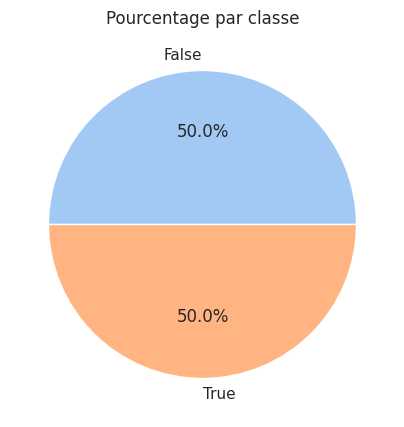

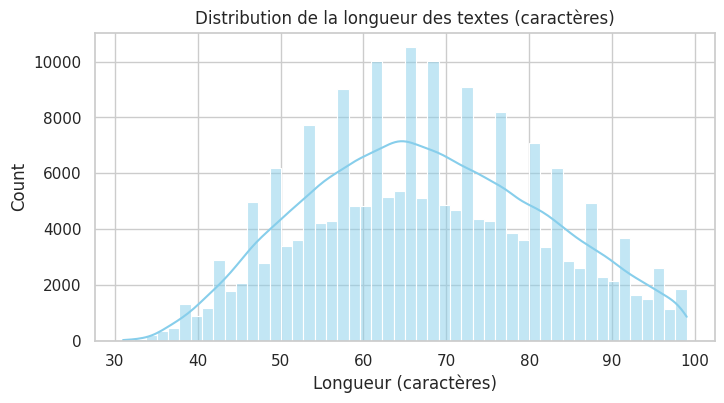

/tmp/ipykernel_91424/4137132412.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='humor', y='text_length_chars', data=df, palette='pastel')


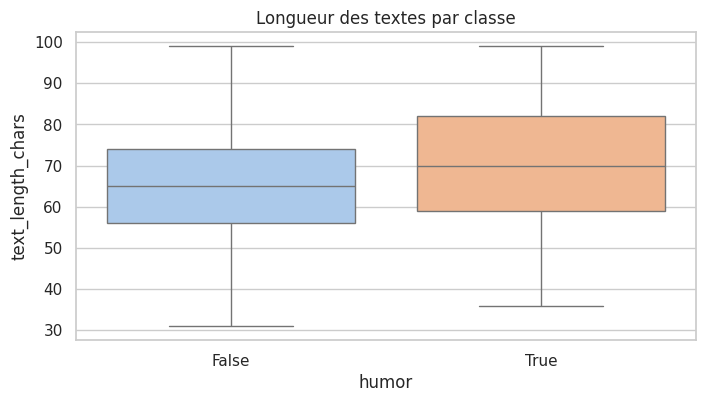


--- Exemples pour la classe False ---


,text
151382,Six quirky reasons to fall in love with portland
160200,Hillary clinton's super pac has raised more mo...
39931,Study: us cities have worse inequality than me...
153307,Rza loves...clarks wallabies? (and more findin...
185999,Trevor noah highlights an awful consequence of...



--- Exemples pour la classe True ---


,text
151508,"When you hold me, i'd prefer it not be account..."
160519,What did the baker name her dog? pido.
39516,I masturbated so good last night that i woke u...
153511,How do you know google is a male? because it k...
185964,Donald trump is so narcissistic... when he loo...



Top 20 tokens pour la classe False:
the(33063), to(29740), s(22806), a(18121), of(17753), in(17723), and(13568), for(13531), is(9877), on(9773), trump(8007), with(7568), you(7405), your(5554), photos(5165), at(5021), t(4976), how(4959), new(4934), it(4615)

Top 20 tokens pour la classe True:
a(59810), the(50149), i(34461), you(32192), what(28196), to(24525), s(20678), do(18373), it(17906), in(15865), of(15298), is(15088), and(14590), my(14100), t(13420), why(11916), did(9975), they(8899), was(8859), he(8756)


In [5]:
# Visualisations détaillées du jeu de données
# - Répartition par classe (barplot + camembert)
# - Distribution de la longueur des textes
# - Exemples d'instances par classe
# - Top tokens simples par classe

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from IPython.display import display

sns.set(style="whitegrid")

# Détection de la colonne texte (essayer plusieurs noms usuels)
text_candidates = ['text', 'sentence', 'content', 'comment', 'post', 'headline', 'joke', 'body']
text_col = next((c for c in text_candidates if c in df.columns), None)
if text_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'humor']
    text_col = obj_cols[0] if obj_cols else None

if text_col is None:
    print("Impossible de trouver automatiquement une colonne texte. Colonnes disponibles :", df.columns.tolist())
else:
    print(f"Utilisation de la colonne texte : '{text_col}'\n")

    # Répartition des classes
    counts = df['humor'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette='pastel')
    plt.xlabel('humor')
    plt.ylabel('Nombre')
    plt.title('Répartition des classes')
    for i, v in enumerate(counts.values):
        plt.text(i, v + max(counts.values) * 0.01, str(v), ha='center')
    plt.show()

    # Camembert (pourcentages)
    plt.figure(figsize=(5,5))
    plt.pie(counts.values, labels=[str(i) for i in counts.index.astype(str)], autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title('Pourcentage par classe')
    plt.show()

    # Longueur des textes (en caractères)
    df['_text_str'] = df[text_col].astype(str)
    df['text_length_chars'] = df['_text_str'].apply(len)
    plt.figure(figsize=(8,4))
    sns.histplot(df['text_length_chars'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution de la longueur des textes (caractères)')
    plt.xlabel('Longueur (caractères)')
    plt.show()

    # Boxplot par classe (longueur)
    plt.figure(figsize=(8,4))
    sns.boxplot(x='humor', y='text_length_chars', data=df, palette='pastel')
    plt.title('Longueur des textes par classe')
    plt.show()

    # Afficher quelques exemples pour chaque classe
    for cls in sorted(df['humor'].unique()):
        print(f"\n--- Exemples pour la classe {cls} ---")
        sample = df[df['humor'] == cls]['_text_str'].dropna()
        if sample.empty:
            print("Aucun exemple trouvé pour cette classe.")
        else:
            display(sample.sample(min(5, len(sample)), random_state=42).to_frame(name=text_col))

    # Top tokens par classe (tokenisation simple)
    def tokenize(text):
        return re.findall(r"\w+", text.lower())

    topn = 20
    for cls in sorted(df['humor'].unique()):
        texts = df[df['humor'] == cls]['_text_str'].dropna().str.cat(sep=' ')
        tokens = tokenize(texts)
        common = Counter(tokens).most_common(topn)
        print(f"\nTop {topn} tokens pour la classe {cls}:")
        print(', '.join([f"{t[0]}({t[1]})" for t in common]))

    # Nettoyage temporaire
    try:
        df.drop(columns=['_text_str'], inplace=True)
    except Exception:
        pass
